In [ ]:
!pip install segmentation_models_pytorch
!wget https://raw.githubusercontent.com/johschmidt42/PyTorch-2D-3D-UNet-Tutorial/master/trainer.py

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!cp drive/MyDrive/RheologyStructure/heterogeneity_zip.zip heterogeneity_zip.zip
!unzip heterogeneity_zip.zip

Archive:  heterogeneity_zip.zip
replace heterogeneity/seismograms/25.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [4]:
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt

Загружаем датасет, рескейлим маски

In [5]:
filenames = sorted(os.listdir("heterogeneity/masks"))
max_num = np.max([int(f[:-4]) for f in filenames]) + 1

In [6]:
seismograms_dict = {i:np.load(f"heterogeneity/seismograms/{i}.npy").transpose(1, 2, 0) for i in range(max_num)}

def rescale_mask(mask):
  return mask[::2, ::2] + mask[1::2, ::2] + mask[::2, 1::2] + mask[1::2, 1::2] >= 2

masks_dict = {i:rescale_mask(np.load(f"heterogeneity/masks/{i}.npy")) for i in range(max_num)}

((1000, 2, 128, 128), (1000, 128, 128))

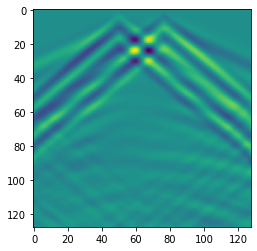

In [7]:
seismograms = np.array([seismograms_dict[i] for i in seismograms_dict])
plt.imshow(seismograms[0,:,:,0])
seismograms = seismograms.transpose(0, 3, 1, 2)
masks = np.array([masks_dict[i] for i in masks_dict]) # .reshape(-1, 128 ** 2)
masks = masks * 1.
seismograms.shape, masks.shape

Или датасет с квадратами

In [8]:
#!ls drive/MyDrive/RheologyStructure/square

In [9]:
#masks = np.load('drive/MyDrive/RheologyStructure/square/mask.npy')
#seismograms = np.load('drive/MyDrive/RheologyStructure/square/seismogram.npy')
#masks, seismograms = np.array([masks]), np.array([seismograms])
#masks.shape, seismograms.shape

Считаем преобразования Фурье для сейсмограм

In [10]:
from numpy.fft import fft2

def transform_seismogram(seismogram):
  seismogram_transformed = []
  for i in range(2):
      transformed = fft2(seismogram[i])
      seismogram_transformed.append(transformed.real)
      seismogram_transformed.append(transformed.imag)
  return np.array(seismogram_transformed)

seismograms_transformed = np.array([transform_seismogram(seismogram) for seismogram in seismograms])
seismograms_transformed.shape

(1000, 4, 128, 128)

In [11]:
seismograms = np.concatenate([seismograms, seismograms_transformed], axis=1)

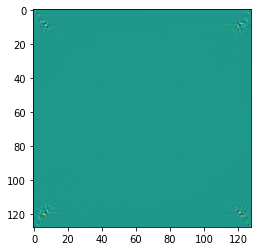

In [12]:
#plt.imshow(] / np.mean(seismograms[0][2]))
st = seismograms[0][2]#np.log(1 + seismograms[0][2])
plt.imshow(st / np.max(st))

In [13]:
#transformed.imag

Какие-то вспомогательные функции

In [14]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.encoders import get_preprocessing_fn
import torch
from torch import nn

In [15]:
class View(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape

    def __repr__(self):
        return f'View{self.shape}'

    def forward(self, input):
        '''
        Reshapes the input according to the shape saved in the view data structure.
        '''
        batch_size = input.size(0)
        shape = (batch_size, *self.shape)
        out = input.view(shape) # [:, 1] # torch.gather(, 1, torch.tensor([0]))
        return out

In [16]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

Делаем датасеты

In [17]:
import torch
from skimage.io import imread
from torch.utils import data


class SegmentationDataSet(data.Dataset):
    def __init__(self,
                 inputs: list,
                 targets: list,
                 transform=None
                 ):
        self.inputs = inputs
        self.targets = targets
        self.transform = transform
        self.inputs_dtype = torch.float32
        self.targets_dtype = torch.long

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self,
                    index: int):
        # Select the sample
        x = self.inputs[index]
        y = self.targets[index]


        # Preprocessing
        if self.transform is not None:
            x, y = self.transform(x, y)

        # Typecasting
        x, y = torch.from_numpy(x).type(self.inputs_dtype), torch.from_numpy(y).type(self.targets_dtype)

        return x, y

In [18]:
seismograms.shape #- np.mean(seismograms)

(1000, 6, 128, 128)

In [23]:
s = seismograms - np.mean(seismograms)
print(s.shape)
s /= np.std(s)
training_dataset = SegmentationDataSet(s[:900] , masks[:900])
training_dataloader = data.DataLoader(dataset=training_dataset,
                                      batch_size=10,
                                      shuffle=True)
val_dataset = SegmentationDataSet(s[900:], masks[900:])
val_dataloader = data.DataLoader(dataset=val_dataset,
                                      batch_size=10,
                                      shuffle=True)

(1000, 6, 128, 128)


Код обучения я вытащил отсюда:
https://raw.githubusercontent.com/johschmidt42/PyTorch-2D-3D-UNet-Tutorial/master/trainer.py


In [24]:
from trainer import Trainer

In [25]:
model = nn.Sequential(
    #torch.nn.BatchNorm2d(2),
    smp.Unet(
    encoder_name="resnet18",  
    in_channels=seismograms.shape[1],      
    classes=2,    
    ),
    #view([2, 128 * 128]),
)


if torch.cuda.is_available():
    model.cuda()

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
loss_fn = torch.nn.CrossEntropyLoss()
trainer = Trainer(model=model,
                  device=device,
                  criterion=criterion,
                  optimizer=optimizer,
                  training_DataLoader=training_dataloader,
                  validation_DataLoader=val_dataloader,
                  lr_scheduler=None,
                  epochs=100,
                  epoch=0,
                  notebook=True)
history = trainer.run_trainer()

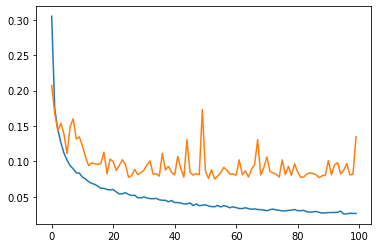

In [26]:
plt.plot(history[0])
plt.plot(history[1])

Рисуем результаты

In [27]:
res = torch.nn.Softmax()(model(torch.tensor(s[950:960] ).float().cuda()))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.


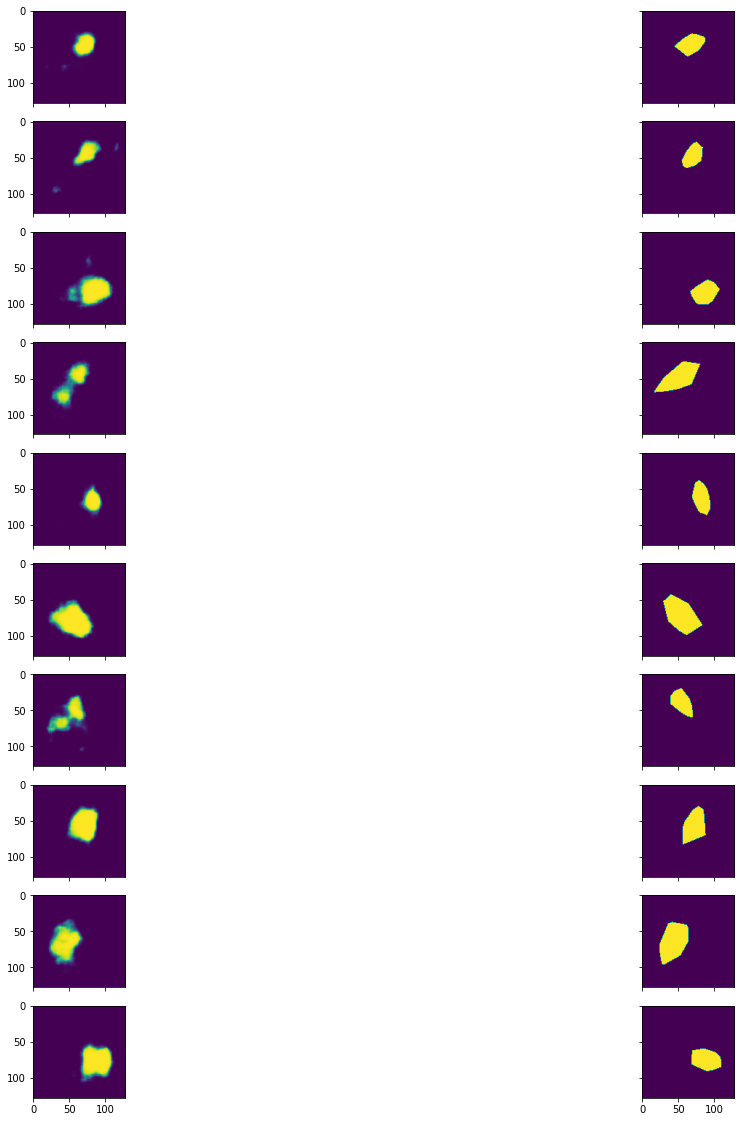

In [28]:
fig, ax = plt.subplots(10, 2, sharey=True, sharex=True, figsize=(20, 20))
fig.patch.set_visible(False)

for i, (pr, gt) in enumerate(zip(res, masks[950:960]), ):
  ax[i][0].imshow(pr.cpu().detach().numpy()[1]) #.shape
  #s = seismograms[900 + i, ][4]
  #s -= np.mean(s)
  #s /= np.std(s)
  #ax[i][1].imshow(s)
  ax[i][1].imshow(gt)

In [49]:
res = torch.nn.Softmax()(model(torch.tensor(s[900:] ).float().cuda())).cpu().detach().numpy()[:,1] >= 0.5
np.mean(res * 1 == masks[900:])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.


0.9743560791015625

In [ ]:
masks_dict[500].shape

(128, 128)